# 산업제어시스템 보안위협 탐지

### import modules

In [1]:
!pip install 'eTaPR-21.8.2-py3-none-any.whl'

import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

Processing ./eTaPR-21.8.2-py3-none-any.whl
eTaPR is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="3"

### Load Data

In [3]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [4]:
TRAIN_DATASET = sorted([x for x in Path("train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("test/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("validation/").glob("*.csv")])

TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)
print(TRAIN_DF_RAW.shape)
TRAIN_DF_RAW.head()

(1004402, 87)


,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503


In [5]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [6]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [7]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [8]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,...,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,...,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,...,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,...,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004397,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,...,0.403941,0.696846,1.000000,0.996289,0.517805,0.0,0.414192,0.0,0.0,0.018717
1004398,0.447224,0.0,0.056338,0.509379,0.994085,0.510481,0.640361,0.0,0.0,0.0,...,0.401381,0.695028,1.000000,0.995484,0.518674,0.0,0.414192,0.0,0.0,0.015676
1004399,0.423251,0.0,0.056338,0.528358,0.994085,0.508101,0.640361,0.0,0.0,0.0,...,0.401571,0.694256,1.000000,0.995510,0.511131,0.0,0.414192,0.0,0.0,0.015440
1004400,0.425407,0.0,0.056338,0.520068,0.993949,0.522157,0.640361,0.0,0.0,0.0,...,0.401590,0.693797,1.000000,0.995761,0.510014,0.0,0.414192,0.0,0.0,0.014318


In [9]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [10]:
boundary_check(TRAIN_DF)

(False, False, False)

In [11]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        
        return item

In [12]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
HAI_DATASET_TRAIN[0]

  0%|          | 0/1004313 [00:00<?, ?it/s]

# of valid windows: 1003868


{'ts': '2021-07-11 10:01:29',
 'given': tensor([[0.4331, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2761],
         [0.3951, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2752],
         [0.3333, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2749],
         ...,
         [0.3205, 0.0000, 0.0548,  ..., 0.0000, 0.0000, 0.0091],
         [0.4451, 0.0000, 0.0562,  ..., 0.0000, 0.0000, 0.0091],
         [0.3477, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.0091]]),
 'answer': tensor([0.3711, 0.0000, 0.0563, 0.5032, 0.1387, 0.4298, 0.8161, 0.0000, 0.0000,
         0.0000, 0.7223, 0.6224, 0.4866, 0.4075, 0.2524, 0.2907, 0.0000, 0.0000,
         0.0000, 0.3050, 0.4108, 0.0000, 0.3492, 0.6516, 0.0120, 0.0000, 0.3563,
         0.3370, 0.0000, 0.9763, 0.5501, 0.3796, 0.3818, 0.0000, 0.9009, 0.0000,
         0.2097, 0.0000, 0.0000, 0.0249, 0.2642, 0.5416, 0.5994, 0.4009, 0.0021,
         1.0000, 0.5253, 1.0000, 0.0000, 0.2244, 0.4755, 0.0000, 0.4874, 0.0509,
         0.0000, 0.3105, 0.7985, 0.1781, 0.2572, 0.4340, 1.

In [13]:
print(HAI_DATASET_TRAIN[0]['given'].shape)
print(HAI_DATASET_TRAIN[0]['answer'].shape)

torch.Size([89, 86])
torch.Size([86])


### Building Model
- input sequence가 길 경우 기존 GRU에 비해 상대적으로 학습에 효율적이며 self-attention을 사용해 한번에 전체 맥락 파악
- Transforme는 DARNN 구조와 같이 encoder에서는 feature attention을 사용하여 context vector 생성
- TimeDistributed를 사용하여 시계열 단위에 layer를 적용해 독립된 Linear를 사용

### Reference
- [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) - Paper
- [A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction](https://arxiv.org/abs/1704.02971) - Paper

In [ ]:
import easydict
import math
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
def get_sinusoid_encoding_table(n_seq, hidn):

    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / hidn)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table


def get_attn_decoder_mask(seq):
    batch, window_size, d_hidn = seq.size()
    subsequent_mask = torch.ones((batch,window_size,window_size), device=seq.device)
    subsequent_mask = subsequent_mask.triu(diagonal=1)
    return subsequent_mask


class scaleddotproductattention(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.dropout = nn.Dropout(self.args.dropout)
        self.scale = 1 / (self.args.d_head ** 0.5)

    def forward(self, q, k, v, attn_mask=False):
        scores = torch.matmul(q, k.transpose(-1, -2))
        scores = scores.mul_(self.scale)

        if attn_mask is not False:
            scores.masked_fill_(attn_mask, -1e9)
            attn_prob = nn.Softmax(dim=-1)(scores)
            attn_prob = self.dropout(attn_prob)
            context = torch.matmul(attn_prob, v)
        else:
            attn_prob = nn.Softmax(dim=-1)(scores)
            attn_prob = self.dropout(attn_prob)
            context = torch.matmul(attn_prob, v)

        return context, attn_prob


class multiheadattention(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.W_Q = nn.Linear(self.args.d_hidn, self.args.n_head * self.args.d_head)
        self.W_K = nn.Linear(self.args.d_hidn, self.args.n_head * self.args.d_head)
        self.W_V = nn.Linear(self.args.d_hidn, self.args.n_head * self.args.d_head)
        self.scaled_dot_attn = scaleddotproductattention(self.args)
        self.linear = nn.Linear(self.args.n_head * self.args.d_head, self.args.d_hidn)
        self.dropout = nn.Dropout(self.args.dropout)

    def forward(self, q, k, v, attn_mask=False):
        batch_size = q.size(0)
        q_s = self.W_Q(q).view(batch_size, -1, self.args.n_head, self.args.d_head).transpose(1,2)
        k_s = self.W_K(k).view(batch_size, -1, self.args.n_head, self.args.d_head).transpose(1,2)
        v_s = self.W_V(v).view(batch_size, -1, self.args.n_head, self.args.d_head).transpose(1,2)

        if attn_mask is not False:
            attn_mask = attn_mask.unsqueeze(1).repeat(1, self.args.n_head, 1, 1)
            context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        else:
            context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.args.n_head * self.args.d_head)

        output = self.linear(context)
        output = self.dropout(output)

        return output, attn_prob


class poswisefeedforwardnet(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.conv1 = nn.Conv1d(in_channels=self.args.d_hidn, out_channels=self.args.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.args.d_ff, out_channels=self.args.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(self.args.dropout)

    def forward(self, inputs):
        output = self.conv1(inputs.transpose(1, 2).contiguous())
        output = self.active(output)
        output = self.conv2(output).transpose(1, 2).contiguous()
        output = self.dropout(output)

        return output


class encoderlayer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.self_attn = multiheadattention(self.args)
        self.pos_ffn = poswisefeedforwardnet(self.args)

    def forward(self, inputs):
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs)
        att_outputs = att_outputs + inputs

        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = ffn_outputs + att_outputs

        return ffn_outputs, attn_prob


class encoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.enc_emb = nn.Linear(in_features=self.args.window_size, out_features=self.args.d_hidn, bias=False)
        nusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.args.e_features , self.args.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(nusoid_table, freeze=True)
        self.layers = nn.ModuleList([encoderlayer(self.args) for _ in range(self.args.n_layer)])
        self.enc_attn_probs = None

    def forward(self, inputs):
        self.enc_attn_probs = []
        positions = torch.arange(inputs.size(2), device=inputs.device).expand(inputs.size(0), inputs.size(2)).contiguous()
        outputs = self.enc_emb(inputs.transpose(2,1).contiguous()) + self.pos_emb(positions)

        for layer in self.layers:
            outputs, enc_attn_prob = layer(outputs)
            self.enc_attn_probs.append(enc_attn_prob)

        return outputs

class decoderlayer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.self_attn = multiheadattention(self.args)
        self.dec_enc_attn = multiheadattention(self.args)
        self.pos_ffn = poswisefeedforwardnet(self.args)

    def forward(self, dec_inputs, enc_outputs, attn_mask):
        self_att_outputs, dec_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, attn_mask)
        self_att_outputs = self_att_outputs + dec_inputs

        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs)
        dec_enc_att_outputs = dec_enc_att_outputs + self_att_outputs

        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = ffn_outputs + dec_enc_att_outputs

        return ffn_outputs, dec_attn_prob, dec_enc_attn_prob


class decoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.dec_emb = nn.Linear(in_features=self.args.d_features, out_features=self.args.d_hidn, bias=False)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.args.window_size , self.args.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)
        self.layers = nn.ModuleList([decoderlayer(self.args) for _ in range(self.args.n_layer)])
        self.dec_attn_probs = None
        self.dec_enc_attn_probs = None

    def forward(self, dec_inputs, enc_outputs):
        self.dec_attn_probs = []
        self.dec_enc_attn_probs = []
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous()
        dec_output = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        attn_mask = torch.gt(get_attn_decoder_mask(dec_inputs),0)

        for layer in self.layers:
            dec_outputs, dec_attn_prob, dec_enc_attn_prob = layer(dec_output, enc_outputs, attn_mask)
            self.dec_attn_probs.append(dec_attn_prob)
            self.dec_enc_attn_probs.append(dec_enc_attn_prob)

        return dec_outputs


class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        y = self.module(x_reshape)

        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y


class transformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.encoder = encoder(self.args)
        self.decoder = decoder(self.args)
        self.fc1 = TimeDistributed(nn.Linear(in_features=self.args.window_size*self.args.d_hidn, out_features=self.args.dense_h))
        self.fc2 = TimeDistributed(nn.Linear(in_features=self.args.dense_h, out_features=self.args.output_size))

    def forward(self, enc_inputs, dec_inputs):
        enc_outputs = self.encoder(enc_inputs)
        dec_outputs = self.decoder(dec_inputs, enc_outputs)

        dec_outputs = self.fc1(dec_outputs.view(dec_outputs.size(0),-1))
        dec_outputs = self.fc2(dec_outputs)

        return dec_outputs

In [16]:
args = easydict.EasyDict({
                        'output_size' : 86,
                        'window_size' : 89,
                        'batch_size' : 1024,
                        'lr' : 1e-3,
                        'e_features' : 86,
                        'd_features' : 86,
                        'd_hidn' : 128,
                        'n_head' : 4,
                        'd_head' : 32,
                        'dropout' : 0.1,
                        'd_ff' : 128,
                        'n_layer' : 3,
                        'dense_h' : 128,
                        'epochs' : 10,
                        'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
                        'save_path' : '/SAVE/'
                        })

In [17]:
model = transformer(args).to(args.device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
dataloader = DataLoader(HAI_DATASET_TRAIN, batch_size=args.batch_size, shuffle=True)

In [18]:
loss_list = []

for epoch in tqdm(range(1, args.epochs+1)):
    total_loss = 0
    n =0

    for data in dataloader:
        input_data = data['given']
        target = data['answer']
        model.train()
        optimizer.zero_grad()
        pred = model(input_data.to(args.device), input_data.to(args.device))
        loss = loss_function(pred, target.to(args.device))
        loss.backward()
        optimizer.step()
        total_loss += (loss*input_data.size()[0])
        n += input_data.size()[0]

    loss_list.append(total_loss/n)

    print('epoch: {}, Train MSE_loss : {:.5f}'.format(epoch, total_loss/n))

 10%|█         | 1/10 [02:49<25:24, 169.42s/it]

epoch: 1, Train MSE_loss : 0.05664


 20%|██        | 2/10 [05:39<22:40, 170.02s/it]

epoch: 2, Train MSE_loss : 0.00320


 30%|███       | 3/10 [08:30<19:51, 170.23s/it]

epoch: 3, Train MSE_loss : 0.00228


 40%|████      | 4/10 [11:20<17:02, 170.35s/it]

epoch: 4, Train MSE_loss : 0.00170


 50%|█████     | 5/10 [14:11<14:12, 170.43s/it]

epoch: 5, Train MSE_loss : 0.00132


 60%|██████    | 6/10 [17:02<11:22, 170.50s/it]

epoch: 6, Train MSE_loss : 0.00103


 70%|███████   | 7/10 [19:52<08:31, 170.45s/it]

epoch: 7, Train MSE_loss : 0.00081


 80%|████████  | 8/10 [22:42<05:40, 170.49s/it]

epoch: 8, Train MSE_loss : 0.00065


 90%|█████████ | 9/10 [25:33<02:50, 170.45s/it]

epoch: 9, Train MSE_loss : 0.00054


100%|██████████| 10/10 [28:23<00:00, 170.36s/it]

epoch: 10, Train MSE_loss : 0.00047


In [19]:
# 모델 저장
torch.save(model.state_dict(), 'transfomer_10')

In [20]:
# 모델 생성
model = transformer(args).to(args.device)

# 저장된 model 불러오기
with open('transfomer_10', "rb") as f:
     saved_state_dict = torch.load(f)
model.load_state_dict(saved_state_dict)

<All keys matched successfully>

### evaluation

In [21]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
86397,2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0
86398,2021-07-10 23:59:59,-2.1541,0,12.26196,-0.00166,15.53497,0.3280,12.669310,70,1,...,31.77029,0.716042,1130.65723,349.13916,1,1018.394040,12.0,50,7,0


In [22]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [23]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [24]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]

  0%|          | 0/86311 [00:00<?, ?it/s]

# of valid windows: 86311


{'attack': 0.0,
 'ts': '2021-07-10 00:01:30',
 'given': tensor([[ 0.4743,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0208],
         [ 0.4517,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0204],
         [ 0.3819,  0.0000, -0.0421,  ...,  0.0000,  0.0000,  0.0200],
         ...,
         [ 0.4541,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4627,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4740,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090]]),
 'answer': tensor([ 3.3894e-01,  0.0000e+00, -4.0688e-02,  5.5241e-01,  1.4881e-01,
          4.1252e-01,  1.1192e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.0504e-01,  5.4733e-01,  4.3329e-01,  5.1462e-01,  3.9176e-01,
          2.2703e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.4392e-01,
          5.1435e-01,  0.0000e+00,  4.3473e-01,  2.6757e-01,  1.0783e-01,
          0.0000e+00,  4.3937e-01,  3.6840e-01,  0.0000e+00,  9.9556e-01,
          5.8627e-01,  2.9203e-01,  2.2335e-01,  

In [25]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given, given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [26]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, model, args.batch_size)

CPU times: user 5.82 s, sys: 36 ms, total: 5.86 s
Wall time: 5.87 s


In [27]:
def range_check(series, size):
    data = []
    
    for i in range(size, len(series)+1):
        if i == size :
            check_std = np.std(series[i-size:i])
        std = np.std(series[i-size:i])
        mean = np.mean(series[i-size:i])
        max = np.max(series[i-size:i])
        check_std
        if check_std * 2 >= std:
            check_std = std
            data.append(mean)
        elif max == series[i]:
            data.append(max*5)
            check_std = std
        else:
            data.append(series[i]*3)
    for _ in range(size-1):
        data.append(mean)

    return np.array(data)

In [28]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
C_ANOMALY_SCORE = range_check(ANOMALY_SCORE, size=30)
print(C_ANOMALY_SCORE.shape)

(86311,)


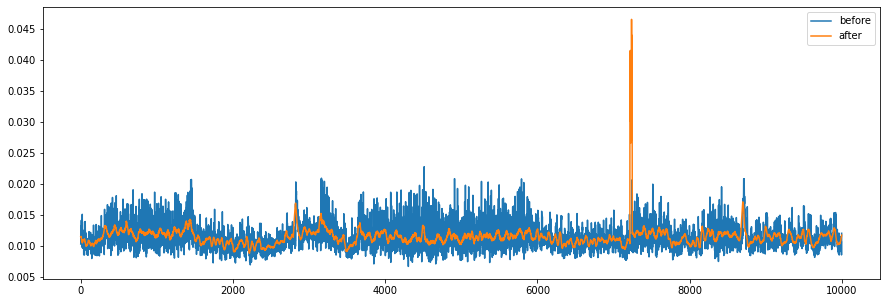

In [29]:
plt.figure(figsize=(15,5))
plt.plot(ANOMALY_SCORE[10000:20000], label='before')
plt.plot(C_ANOMALY_SCORE[10000:20000], label='after')
plt.legend()
plt.show()

In [30]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = np.max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

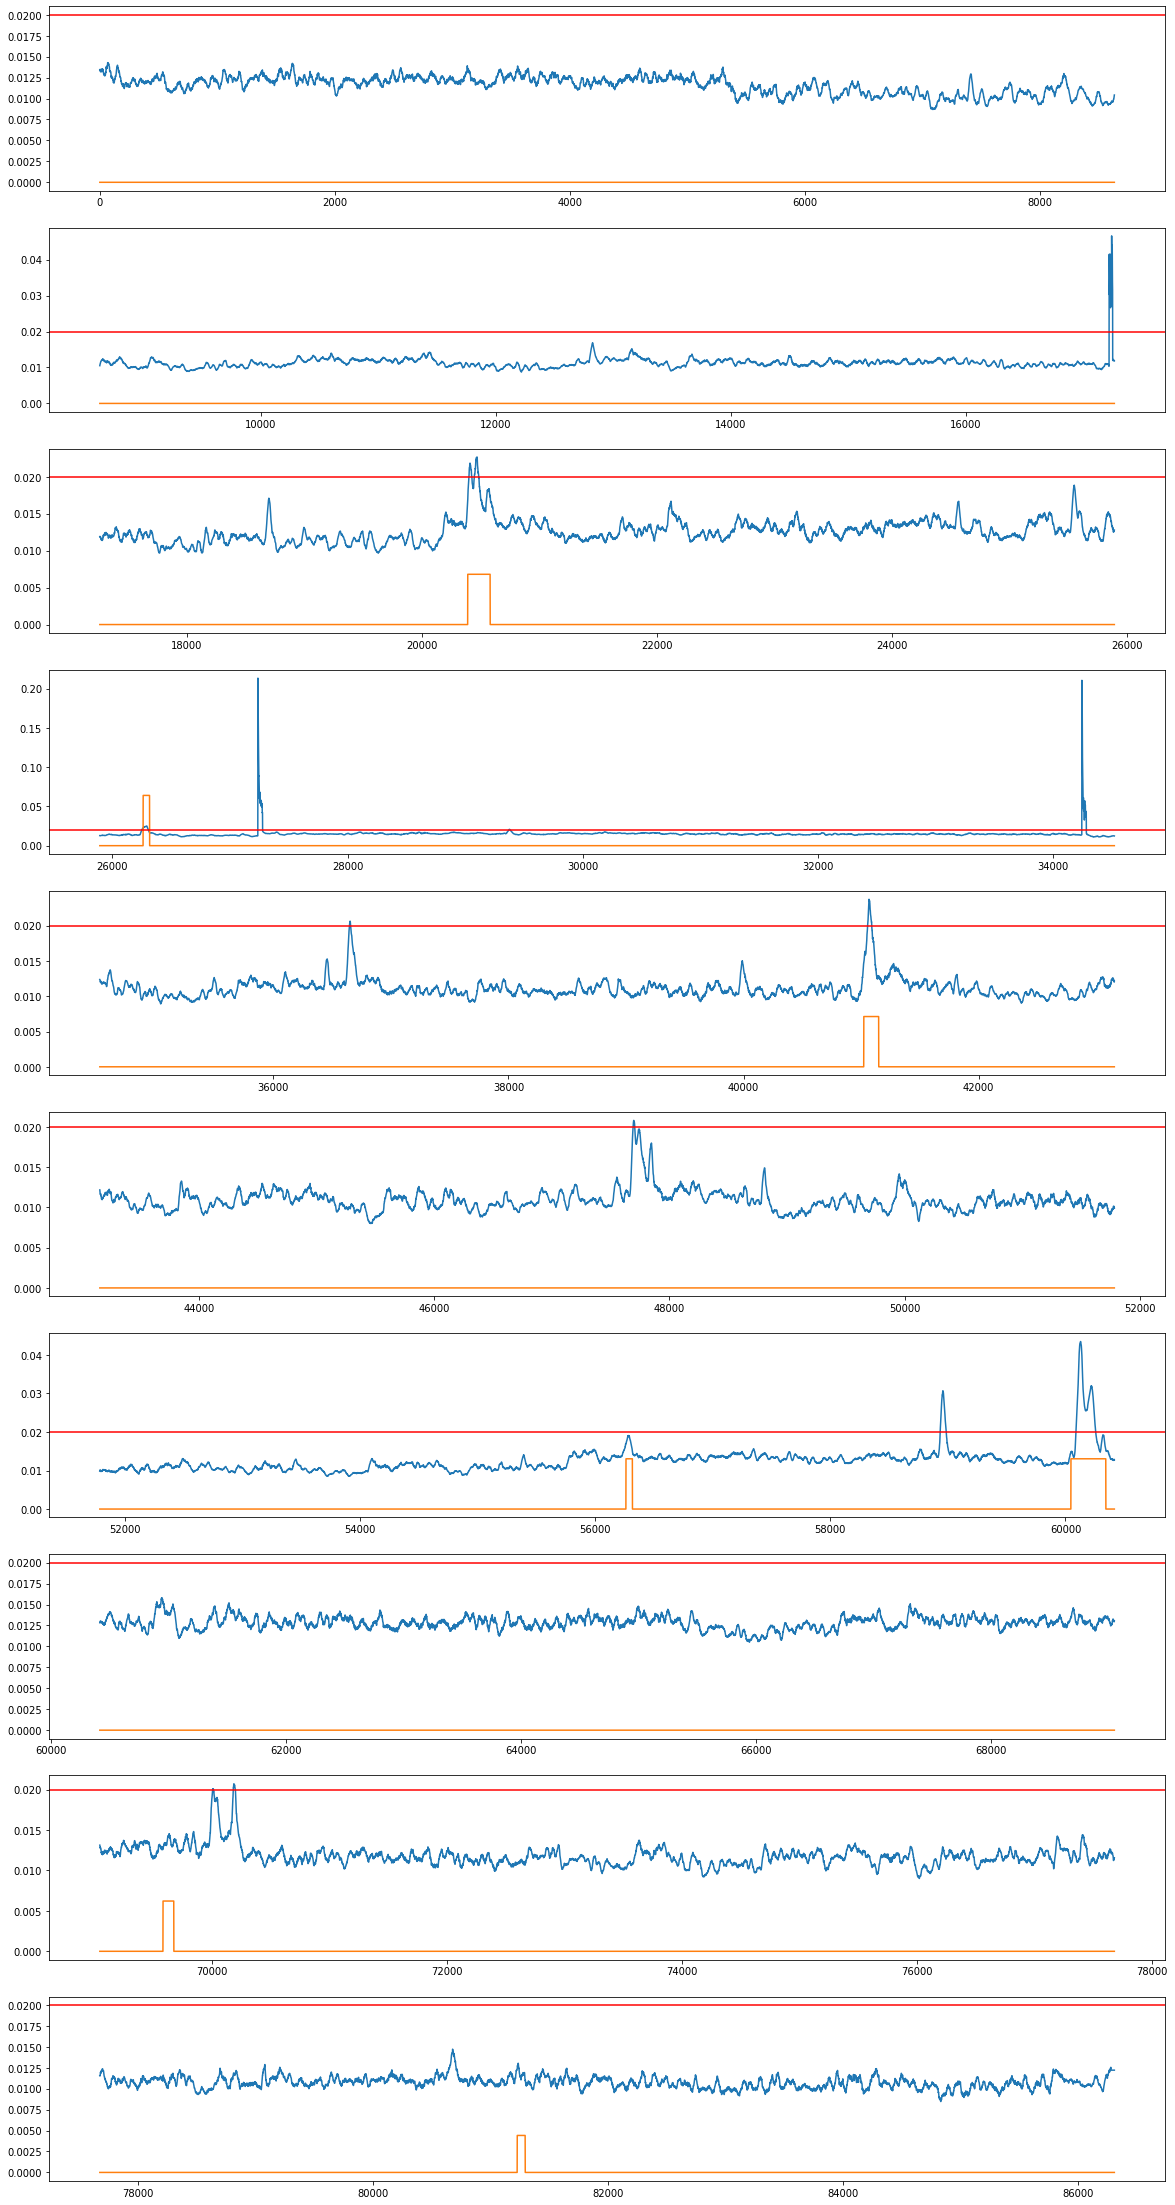

In [31]:
THRESHOLD = 0.02
check_graph(C_ANOMALY_SCORE, CHECK_ATT, piece=10, THRESHOLD=THRESHOLD)

In [32]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [33]:
LABELS = put_labels(C_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (86311,))

In [34]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [35]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [36]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 10.7 s, sys: 3.92 ms, total: 10.7 s
Wall time: 10.7 s


(86400,)

In [37]:
# 0.2
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.307 (TaP: 0.272, TaR: 0.353)
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fe01c515ef0>, <TaPR_pkg.DataManage.Range.Range object at 0x7fe01c515f60>, <TaPR_pkg.DataManage.Range.Range object at 0x7fe01c515668>, <TaPR_pkg.DataManage.Range.Range object at 0x7fe01c58d518>]


### inference

In [38]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,...,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,...,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,...,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,...,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,...,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,...,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,...,0.92255,29.45758,2.40398,1026.05530,376.66376,1,1015.06964,12.0,50,22
129597,2021-07-16 23:59:58,-1.5833,0,12.07123,-0.00130,13.64288,0.9984,12.58870,70,1,...,0.92255,29.45034,2.40398,981.37659,377.76691,1,1015.06964,12.0,50,22
129598,2021-07-16 23:59:59,-1.4022,0,12.07123,0.00087,13.62762,1.0595,12.58870,70,1,...,0.92255,29.43088,2.40398,919.62439,378.99664,1,1015.06964,12.0,50,22


In [39]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.455432,0.0,0.079812,0.479046,0.077046,0.434169,0.711769,0.0,0.0,0.0,...,0.378726,0.095024,0.285153,0.068104,0.381526,0.0,0.393961,0.0,0.0,0.168791
1,0.471678,0.0,0.079812,0.499628,0.077046,0.429998,0.711769,0.0,0.0,0.0,...,0.377826,0.099579,0.285153,0.069240,0.404094,0.0,0.393961,0.0,0.0,0.173300
2,0.459304,0.0,0.079812,0.482713,0.077046,0.410346,0.711769,0.0,0.0,0.0,...,0.378191,0.103601,0.285153,0.068779,0.429462,0.0,0.393961,0.0,0.0,0.176731
3,0.458079,0.0,0.079812,0.478654,0.077046,0.408400,0.711769,0.0,0.0,0.0,...,0.379124,0.109204,0.285153,0.068734,0.461282,0.0,0.393961,0.0,0.0,0.178719
4,0.380719,0.0,0.079812,0.515098,0.077046,0.367874,0.711769,0.0,0.0,0.0,...,0.379218,0.109763,0.285153,0.066761,0.472272,0.0,0.393961,0.0,0.0,0.182832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.511523,0.0,0.017216,0.516825,0.147339,0.557125,0.711717,0.0,0.0,0.0,...,0.245764,0.130889,0.240398,0.327644,0.529605,0.0,0.539339,0.0,0.0,0.010225
129596,0.512114,0.0,0.017216,0.461690,0.135262,0.557380,0.711717,0.0,0.0,0.0,...,0.241081,0.131212,0.240398,0.320111,0.540804,0.0,0.539339,0.0,0.0,0.010225
129597,0.553332,0.0,0.017216,0.493026,0.133167,0.590276,0.711717,0.0,0.0,0.0,...,0.240613,0.130586,0.240398,0.306708,0.545617,0.0,0.539339,0.0,0.0,0.010225
129598,0.587329,0.0,0.017216,0.519678,0.132821,0.603950,0.711717,0.0,0.0,0.0,...,0.240566,0.128753,0.240398,0.287885,0.550216,0.0,0.539339,0.0,0.0,0.010225


In [40]:
boundary_check(TEST_DF)

(True, True, False)

In [41]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_TEST[0]

  0%|          | 0/274711 [00:00<?, ?it/s]

# of valid windows: 274533


{'ts': '2021-07-13 16:01:30',
 'given': tensor([[0.4554, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1688],
         [0.4717, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1733],
         [0.4593, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1767],
         ...,
         [0.3050, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.0091],
         [0.3005, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.0091],
         [0.3201, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.0091]]),
 'answer': tensor([0.3561, 0.0000, 0.0798, 0.4972, 0.1030, 0.3958, 0.7118, 0.0000, 0.0000,
         0.0000, 0.3254, 0.4196, 0.4210, 0.3090, 0.5363, 0.2660, 0.0000, 0.0000,
         0.0000, 0.6997, 0.3088, 0.0000, 0.3013, 0.3171, 0.0066, 0.0000, 0.3031,
         0.3929, 0.0000, 0.8325, 0.4142, 0.2806, 0.4318, 0.0000, 0.2850, 0.0000,
         0.0577, 0.0000, 0.0000, 0.0186, 0.3402, 0.4977, 0.4490, 0.3920, 1.0000,
         1.0000, 0.9935, 1.0000, 0.0000, 0.0139, 0.7703, 0.0000, 0.6502, 0.0082,
         0.0000, 0.3030, 0.3181, 0.1386, 0.2675, 0.3540, 1.

In [42]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, model, args.batch_size)

CPU times: user 18 s, sys: 360 ms, total: 18.3 s
Wall time: 18.3 s


In [44]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
C_ANOMALY_SCORE = range_check(ANOMALY_SCORE, size=30)
print(C_ANOMALY_SCORE.shape)

(274533,)


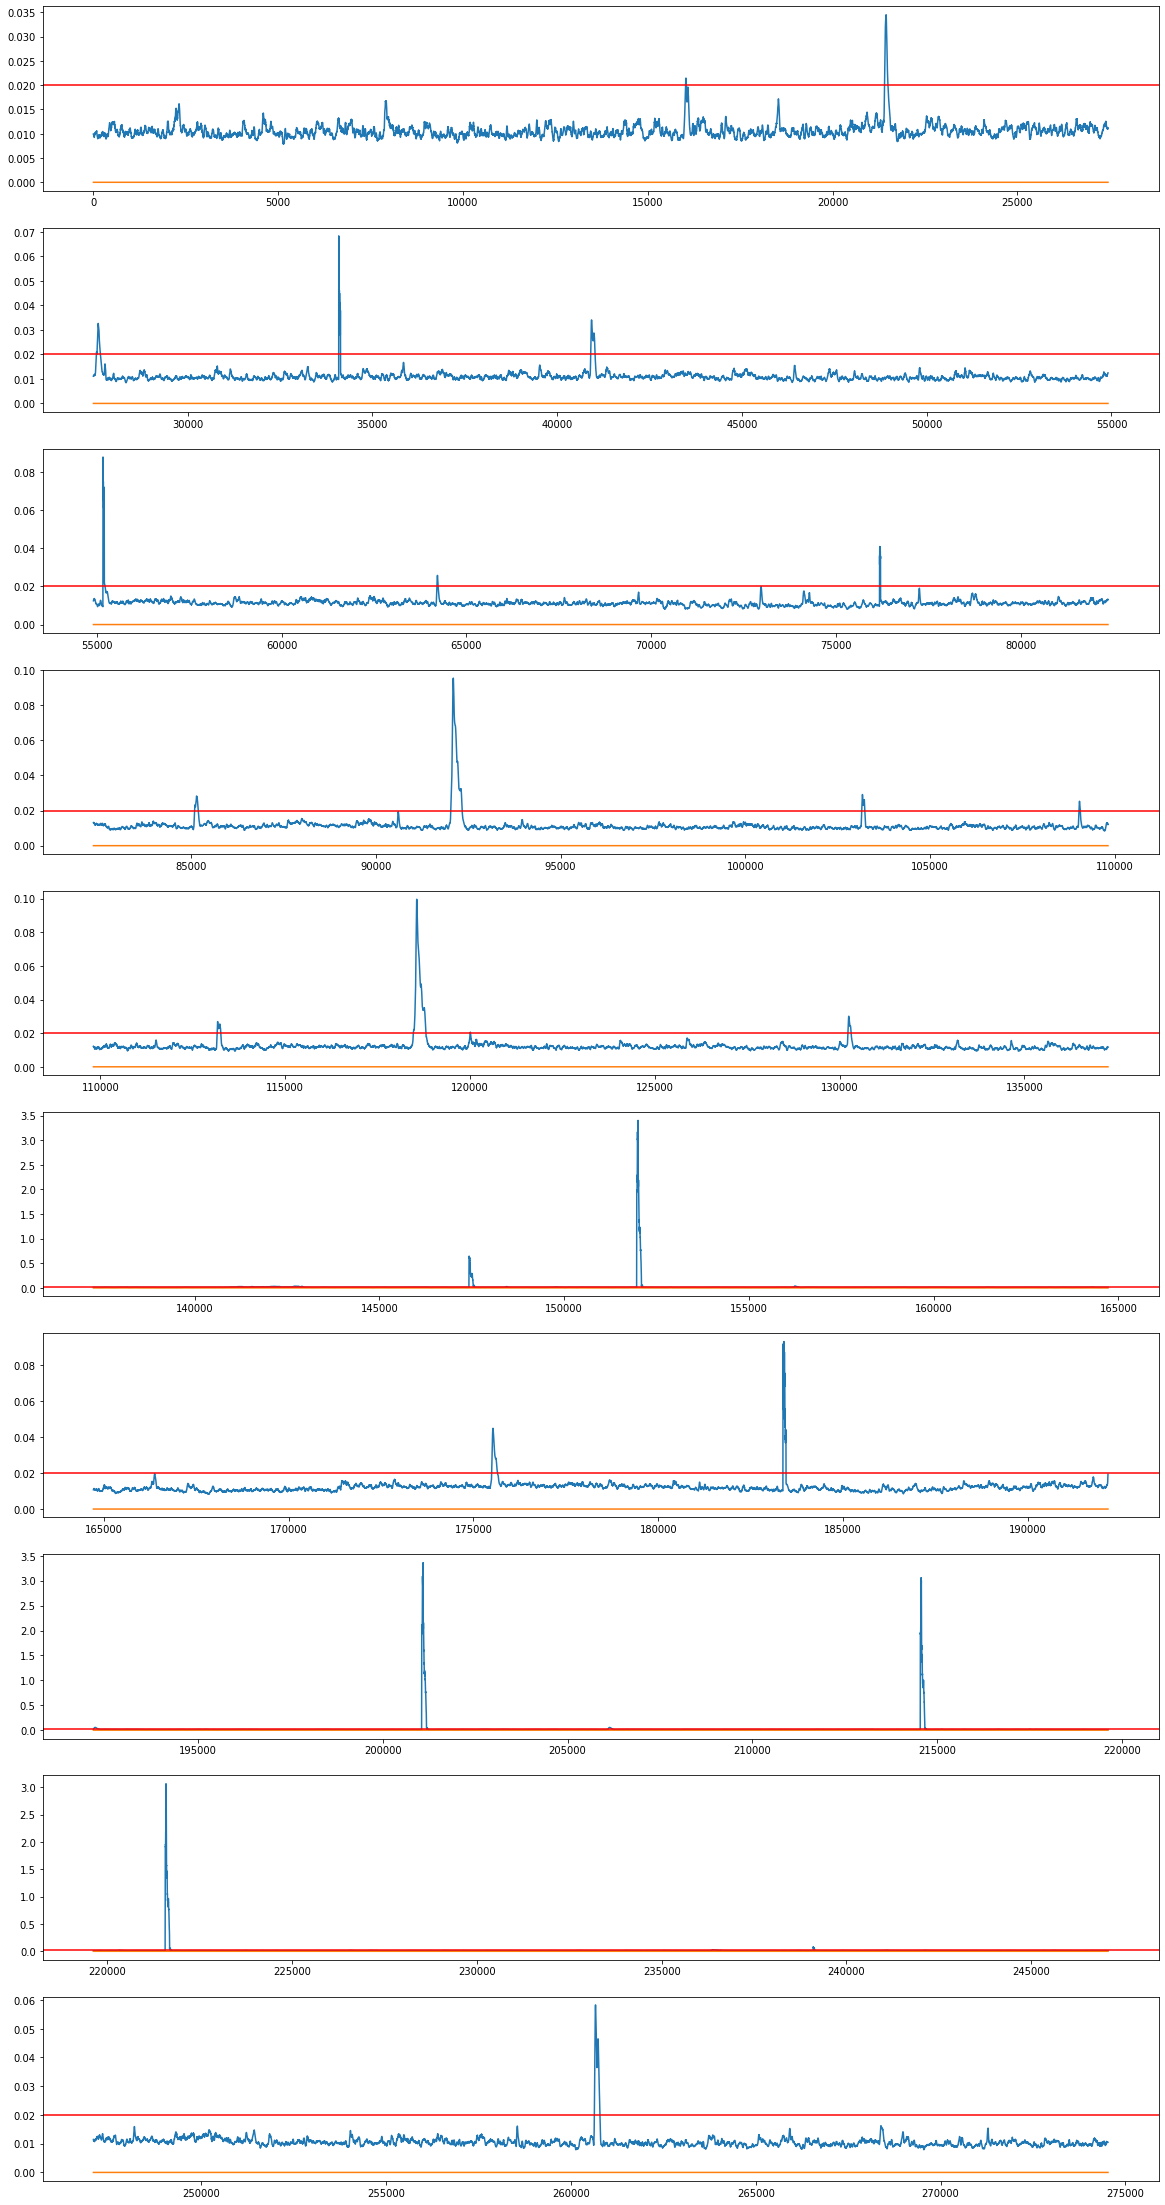

In [45]:
check_graph(C_ANOMALY_SCORE, CHECK_ATT, piece=10, THRESHOLD=THRESHOLD)

In [46]:
LABELS = put_labels(C_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (274533,))

In [47]:
submission = pd.read_csv('sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [48]:
submission.to_csv('transformer_baseline.csv', index=False)